In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

In [ ]:
def img_sample(link):
  info =[]
  for root, __, files in os.walk(link):
    for f in files:
        if f.endswith(".png"):
          img = Image.open(os.path.join(root, f))
          info.append(img)
  return info

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Covid = img_sample('/content/drive/MyDrive/Long_Covid/Covid19')
normal = img_sample('/content/drive/MyDrive/Long_Covid/images')

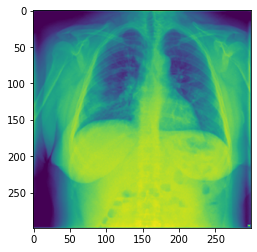

In [ ]:
%matplotlib inline 
plt.imshow(Covid[0])

In [ ]:
X = []
for i in Covid:
  img2arr = np.array(i)
  resized_img = cv2.resize(img2arr,(128,128))
  X.append(resized_img)

for i in normal:
  img2arr = np.array(i)
  resized_img = cv2.resize(img2arr,(128,128))
  X.append(resized_img)

In [ ]:
dataset = np.array(X)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [ ]:
def discriminator(int_shape = (128,128,1)):
  model = keras.Sequential([
                            keras.layers.Conv2D(18,(3,3),padding='same',input_shape=int_shape),
                            keras.layers.LeakyReLU(alpha=0.2),
                            keras.layers.Conv2D(32,(3,3),padding='same',strides=(2, 2)),
                            keras.layers.LeakyReLU(alpha=0.2),
                            keras.layers.Flatten(),
                            keras.layers.Dropout(0.3),
                            keras.layers.Dense(1000,activation='relu'),
                            keras.layers.Dense(1,activation='sigmoid')
  ])
  opt = Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(
      optimizer=opt,
      loss='binary_crossentropy',
      metrics = ['accuracy']
  )
  return model

In [ ]:
model_D = discriminator()

In [ ]:
def generator(latent_dim=100):
  model = keras.Sequential([
                            keras.layers.Dense(16*16*300,input_dim=latent_dim),
                            keras.layers.LeakyReLU(alpha=0.3),
                            keras.layers.Reshape((16,16,300)),

                            keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'),
                            keras.layers.LeakyReLU(alpha=0.2),
                            
                            keras.layers.Conv2DTranspose(96,(3,3),strides=(2,2),padding='same'),
                            keras.layers.LeakyReLU(alpha=0.2),
                            
                            keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same'),
                            keras.layers.LeakyReLU(alpha=0.3),
                            keras.layers.Conv2D(1,(3,3),activation='tanh',padding='same'),
  ])
  return model

In [ ]:
def GAN(model_D,model_G):
  model_D.trainable = False
  model = Sequential()
  model.add(model_G)
  model.add(model_D)
  opt = Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

In [ ]:
model_G = generator()

In [ ]:
model_GAN = GAN(model_D,model_G)

In [ ]:
def generate_real_image(dataset,n_sample):
  i = np.random.randint(0,dataset.shape[0],n_sample)
  X = dataset[i]
  y = y = np.ones((n_sample, 1))
  return X,y

In [ ]:
model_G.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 524288)            52953088  
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 524288)            0         
                                                                 
 reshape_9 (Reshape)         (None, 32, 32, 512)       0         
                                                                 
 conv2d_transpose_33 (Conv2D  (None, 32, 32, 256)      1179904   
 Transpose)                                                      
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_34 (Conv2D  (None, 64, 64, 128)      295040    
 Transpose)                                          

In [ ]:
def generate_fake_image(latent_dim,n_sample,model_G):
  X_input = latent_point(latent_dim,n_sample)
  X = model_G.predict(X_input)
  X = X.reshape(X.shape[0],X.shape[1],X.shape[2])
  y = np.zeros((n_sample, 1))
  return X,y

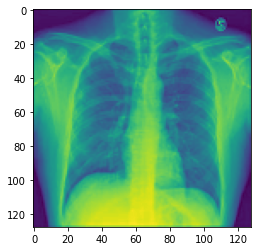

In [ ]:
X,y = generate_real_image(dataset,n_sample=5)
plt.imshow(X[0])

In [ ]:
def plot_images(images, n):
	# scales image values in the range of [0,1]
	images = (images-images.min())/(images.max() - images.min())
	for i in range(n):
		# define subplot
		plt.subplot(1, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(images[i, :, :],cmap='gray')
	plt.show()

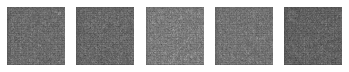

In [ ]:
X,y = generate_fake_image(100,5,model_G)
plot_images(X, 5)

In [ ]:
def latent_point(latent_dim,n_sample):
  X = np.random.randn(latent_dim*n_sample)
  X = X.reshape(n_sample,latent_dim)
  return X

In [ ]:
latent_dim = 100

In [ ]:
def summarize_performance(epoch, model_G, model_D, dataset, latent_dim, n_samples=100):
  model_G.save('/content/drive/MyDrive/GAN' +str(epoch)+ '.h5')
  X_real, y_real = generate_real_image(dataset, n_samples)
  _, acc_real = model_D.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_image(latent_dim, n_samples,model_G)
  _, acc_fake = model_D.evaluate(x_fake, y_fake, verbose=0)
  print('Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [ ]:
def train_GAN(model_G, model_D, model_GAN, dataset, latent_dim, n_epochs=50, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_image(dataset, half_batch)
			X_fake, y_fake = generate_fake_image(latent_dim, half_batch,model_G)
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			d_loss, _ = model_D.train_on_batch(X, y)
			X_gan = latent_point(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = model_GAN.train_on_batch(X_gan, y_gan)
			print('%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		

		X_temp,y_temp = generate_fake_image(latent_dim, 5,model_G)
		plot_images(X_temp,5)

		# evaluate the model performance
		if (i+1) % 10 == 0:
			summarize_performance(i, model_G, model_D, dataset, latent_dim)

1, 1/53, d=28.463, g=0.686
1, 2/53, d=0.369, g=0.680
1, 3/53, d=0.399, g=0.651
1, 4/53, d=0.443, g=0.596
1, 5/53, d=0.504, g=0.524
1, 6/53, d=0.589, g=0.444
1, 7/53, d=0.699, g=0.359
1, 8/53, d=0.839, g=0.285
1, 9/53, d=1.000, g=0.223
1, 10/53, d=1.140, g=0.188
1, 11/53, d=1.242, g=0.178
1, 12/53, d=1.282, g=0.202
1, 13/53, d=1.222, g=0.275
1, 14/53, d=1.132, g=0.456
1, 15/53, d=0.997, g=0.790
1, 16/53, d=0.778, g=1.356
1, 17/53, d=0.549, g=2.028
1, 18/53, d=0.407, g=2.434
1, 19/53, d=0.372, g=2.465
1, 20/53, d=0.208, g=2.807
1, 21/53, d=261.486, g=0.000
1, 22/53, d=8.005, g=0.000
1, 23/53, d=11.921, g=0.000
1, 24/53, d=13.528, g=0.000
1, 25/53, d=13.920, g=0.000
1, 26/53, d=13.563, g=0.000
1, 27/53, d=13.020, g=0.000
1, 28/53, d=11.889, g=0.000
1, 29/53, d=10.752, g=0.000
1, 30/53, d=9.858, g=0.000
1, 31/53, d=8.107, g=0.000
1, 32/53, d=7.227, g=0.000
1, 33/53, d=5.778, g=0.001
1, 34/53, d=4.631, g=0.012
1, 35/53, d=3.283, g=0.083
1, 36/53, d=3.528, g=0.063
1, 37/53, d=4.082, g=0.026


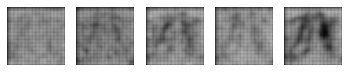

2, 1/53, d=18.364, g=0.000
2, 2/53, d=16.108, g=0.000
2, 3/53, d=13.376, g=0.000
2, 4/53, d=11.051, g=0.000
2, 5/53, d=8.592, g=0.000
2, 6/53, d=5.714, g=0.008
2, 7/53, d=3.340, g=0.386
2, 8/53, d=1.775, g=1.878
2, 9/53, d=2.493, g=1.457
2, 10/53, d=3.962, g=0.517
2, 11/53, d=3.312, g=1.436
2, 12/53, d=1.584, g=4.938
2, 13/53, d=0.086, g=6.865
2, 14/53, d=0.006, g=7.994
2, 15/53, d=0.001, g=8.382
2, 16/53, d=0.001, g=8.124
2, 17/53, d=0.001, g=8.091
2, 18/53, d=0.001, g=7.778
2, 19/53, d=0.001, g=7.629
2, 20/53, d=0.002, g=7.331
2, 21/53, d=0.001, g=7.294
2, 22/53, d=0.001, g=7.058
2, 23/53, d=0.001, g=6.816
2, 24/53, d=0.002, g=6.659
2, 25/53, d=0.002, g=6.620
2, 26/53, d=0.003, g=6.545
2, 27/53, d=0.003, g=6.670
2, 28/53, d=0.005, g=6.346
2, 29/53, d=0.006, g=6.332
2, 30/53, d=0.005, g=6.382
2, 31/53, d=0.006, g=6.262
2, 32/53, d=0.005, g=6.187
2, 33/53, d=0.009, g=6.391
2, 34/53, d=0.009, g=6.376
2, 35/53, d=0.025, g=6.480
2, 36/53, d=0.019, g=6.577
2, 37/53, d=0.017, g=6.651
2, 38/

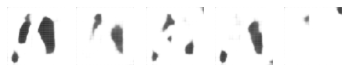

3, 1/53, d=0.115, g=9.824
3, 2/53, d=0.275, g=9.588
3, 3/53, d=0.123, g=10.689
3, 4/53, d=0.243, g=11.783
3, 5/53, d=0.171, g=12.287
3, 6/53, d=0.224, g=12.178
3, 7/53, d=0.151, g=12.902
3, 8/53, d=0.205, g=13.459
3, 9/53, d=0.163, g=13.259
3, 10/53, d=0.224, g=13.839
3, 11/53, d=0.111, g=13.768
3, 12/53, d=0.224, g=13.046
3, 13/53, d=0.234, g=14.217
3, 14/53, d=0.150, g=14.383
3, 15/53, d=0.302, g=14.624
3, 16/53, d=0.070, g=14.108
3, 17/53, d=0.292, g=15.573
3, 18/53, d=0.183, g=15.423
3, 19/53, d=0.283, g=15.095
3, 20/53, d=0.203, g=15.462
3, 21/53, d=0.179, g=15.441
3, 22/53, d=0.238, g=15.950
3, 23/53, d=0.115, g=16.164
3, 24/53, d=3.116, g=11.429
3, 25/53, d=0.570, g=8.135
3, 26/53, d=0.778, g=8.657
3, 27/53, d=0.438, g=8.838
3, 28/53, d=0.481, g=10.049
3, 29/53, d=0.170, g=9.585
3, 30/53, d=0.202, g=11.014
3, 31/53, d=0.163, g=12.648
3, 32/53, d=0.048, g=11.968
3, 33/53, d=0.067, g=11.993
3, 34/53, d=0.021, g=11.931
3, 35/53, d=0.060, g=12.096
3, 36/53, d=0.096, g=12.342
3, 37/5

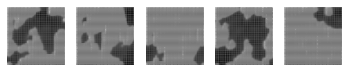

4, 1/53, d=0.000, g=16.308
4, 2/53, d=0.000, g=19.926
4, 3/53, d=0.000, g=21.502
4, 4/53, d=0.000, g=21.997
4, 5/53, d=0.000, g=21.983
4, 6/53, d=0.000, g=19.768
4, 7/53, d=0.000, g=22.305
4, 8/53, d=0.000, g=17.934
4, 9/53, d=0.000, g=15.819
4, 10/53, d=0.000, g=15.382
4, 11/53, d=0.000, g=14.527
4, 12/53, d=0.000, g=14.143
4, 13/53, d=0.000, g=13.718
4, 14/53, d=0.000, g=13.097
4, 15/53, d=0.000, g=13.244
4, 16/53, d=0.000, g=13.455
4, 17/53, d=0.000, g=13.416
4, 18/53, d=0.000, g=12.479
4, 19/53, d=0.000, g=13.268
4, 20/53, d=0.000, g=13.011
4, 21/53, d=0.000, g=12.862
4, 22/53, d=0.000, g=13.270
4, 23/53, d=0.000, g=13.335
4, 24/53, d=0.000, g=13.140
4, 25/53, d=0.000, g=13.038
4, 26/53, d=0.000, g=12.818
4, 27/53, d=0.000, g=12.960
4, 28/53, d=0.000, g=13.339
4, 29/53, d=0.000, g=13.068
4, 30/53, d=0.000, g=13.288
4, 31/53, d=0.000, g=13.049
4, 32/53, d=0.000, g=13.099
4, 33/53, d=0.000, g=13.243
4, 34/53, d=0.000, g=12.901
4, 35/53, d=0.000, g=12.851
4, 36/53, d=0.000, g=12.572
4

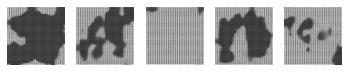

5, 1/53, d=0.000, g=12.502
5, 2/53, d=0.000, g=11.695
5, 3/53, d=0.000, g=11.922
5, 4/53, d=0.001, g=11.431
5, 5/53, d=0.001, g=11.124
5, 6/53, d=0.001, g=11.281
5, 7/53, d=0.001, g=11.302
5, 8/53, d=0.001, g=10.998
5, 9/53, d=0.000, g=11.643
5, 10/53, d=0.000, g=13.784
5, 11/53, d=0.000, g=11.842
5, 12/53, d=0.000, g=11.574
5, 13/53, d=0.000, g=12.127
5, 14/53, d=0.000, g=10.983
5, 15/53, d=0.001, g=11.275
5, 16/53, d=0.000, g=11.323
5, 17/53, d=0.001, g=11.457
5, 18/53, d=0.001, g=10.925
5, 19/53, d=0.001, g=11.505
5, 20/53, d=0.000, g=11.373
5, 21/53, d=0.001, g=11.053
5, 22/53, d=0.001, g=11.001
5, 23/53, d=0.001, g=11.151
5, 24/53, d=0.001, g=10.766
5, 25/53, d=0.001, g=11.363
5, 26/53, d=0.001, g=10.804
5, 27/53, d=0.001, g=10.167
5, 28/53, d=0.001, g=10.547
5, 29/53, d=0.001, g=10.868
5, 30/53, d=0.000, g=11.220
5, 31/53, d=0.000, g=12.672
5, 32/53, d=0.000, g=11.344
5, 33/53, d=0.000, g=12.023
5, 34/53, d=0.000, g=12.326
5, 35/53, d=0.000, g=12.296
5, 36/53, d=0.000, g=11.238
5

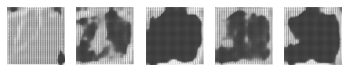

6, 1/53, d=0.000, g=10.556
6, 2/53, d=0.000, g=10.580
6, 3/53, d=0.000, g=10.437
6, 4/53, d=0.000, g=10.713
6, 5/53, d=0.000, g=10.832
6, 6/53, d=0.000, g=10.766
6, 7/53, d=0.000, g=10.397
6, 8/53, d=0.000, g=10.657
6, 9/53, d=0.000, g=10.840
6, 10/53, d=0.000, g=10.358
6, 11/53, d=0.000, g=10.445
6, 12/53, d=0.000, g=10.167
6, 13/53, d=0.000, g=9.986
6, 14/53, d=0.000, g=9.850
6, 15/53, d=0.000, g=9.551
6, 16/53, d=0.000, g=9.651
6, 17/53, d=0.001, g=9.162
6, 18/53, d=0.001, g=9.498
6, 19/53, d=0.000, g=10.000
6, 20/53, d=0.000, g=10.043
6, 21/53, d=0.000, g=10.397
6, 22/53, d=0.000, g=10.308
6, 23/53, d=0.000, g=10.880
6, 24/53, d=0.000, g=11.136
6, 25/53, d=0.000, g=10.845
6, 26/53, d=0.000, g=10.648
6, 27/53, d=0.000, g=10.667
6, 28/53, d=0.000, g=10.733
6, 29/53, d=0.000, g=10.814
6, 30/53, d=0.000, g=10.784
6, 31/53, d=0.000, g=11.006
6, 32/53, d=0.000, g=10.619
6, 33/53, d=0.000, g=10.763
6, 34/53, d=0.000, g=10.802
6, 35/53, d=0.000, g=10.498
6, 36/53, d=0.000, g=10.487
6, 37/5

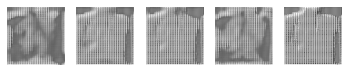

7, 1/53, d=0.000, g=10.926
7, 2/53, d=0.000, g=11.355
7, 3/53, d=0.000, g=11.959
7, 4/53, d=0.000, g=11.312
7, 5/53, d=0.000, g=11.377
7, 6/53, d=0.000, g=11.173
7, 7/53, d=0.000, g=11.041
7, 8/53, d=0.000, g=10.801
7, 9/53, d=0.000, g=10.872
7, 10/53, d=0.000, g=11.066
7, 11/53, d=0.000, g=11.497
7, 12/53, d=0.000, g=11.564
7, 13/53, d=0.000, g=11.362
7, 14/53, d=0.000, g=11.434
7, 15/53, d=0.000, g=12.375
7, 16/53, d=0.000, g=11.268
7, 17/53, d=0.000, g=11.316
7, 18/53, d=0.000, g=10.988
7, 19/53, d=0.000, g=10.831
7, 20/53, d=0.000, g=11.213
7, 21/53, d=0.000, g=11.670
7, 22/53, d=0.000, g=11.429
7, 23/53, d=0.000, g=10.853
7, 24/53, d=0.000, g=11.346
7, 25/53, d=0.000, g=10.837
7, 26/53, d=0.000, g=11.045
7, 27/53, d=0.000, g=10.866
7, 28/53, d=0.000, g=10.948
7, 29/53, d=0.000, g=11.005
7, 30/53, d=0.000, g=10.974
7, 31/53, d=0.000, g=10.906
7, 32/53, d=0.000, g=10.893
7, 33/53, d=0.000, g=11.138
7, 34/53, d=0.000, g=10.919
7, 35/53, d=0.000, g=11.061
7, 36/53, d=0.000, g=10.802
7

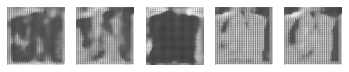

8, 1/53, d=0.000, g=10.985
8, 2/53, d=0.000, g=11.139
8, 3/53, d=0.000, g=11.116
8, 4/53, d=0.000, g=10.984
8, 5/53, d=0.000, g=10.985
8, 6/53, d=0.000, g=11.057
8, 7/53, d=0.000, g=11.028
8, 8/53, d=0.000, g=11.203
8, 9/53, d=0.000, g=11.116
8, 10/53, d=0.000, g=11.291
8, 11/53, d=0.000, g=11.137
8, 12/53, d=0.000, g=11.050
8, 13/53, d=0.000, g=11.181
8, 14/53, d=0.000, g=11.039
8, 15/53, d=0.000, g=11.171
8, 16/53, d=0.000, g=11.184
8, 17/53, d=0.000, g=11.153
8, 18/53, d=0.000, g=11.213
8, 19/53, d=0.000, g=11.365
8, 20/53, d=0.000, g=11.300
8, 21/53, d=0.000, g=11.358
8, 22/53, d=0.000, g=11.285
8, 23/53, d=0.000, g=11.276
8, 24/53, d=0.000, g=11.210
8, 25/53, d=0.000, g=11.112
8, 26/53, d=0.000, g=11.425
8, 27/53, d=0.000, g=11.223
8, 28/53, d=0.000, g=11.328
8, 29/53, d=0.000, g=11.266
8, 30/53, d=0.000, g=11.290
8, 31/53, d=0.000, g=11.431
8, 32/53, d=0.000, g=11.396
8, 33/53, d=0.000, g=11.298
8, 34/53, d=0.000, g=11.158
8, 35/53, d=0.000, g=11.445
8, 36/53, d=0.000, g=11.372
8

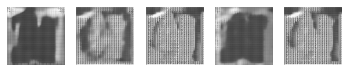

9, 1/53, d=0.000, g=11.196
9, 2/53, d=0.000, g=11.130
9, 3/53, d=0.000, g=11.205
9, 4/53, d=0.000, g=11.220
9, 5/53, d=0.000, g=11.115
9, 6/53, d=0.000, g=11.321
9, 7/53, d=0.000, g=11.382
9, 8/53, d=0.000, g=11.319
9, 9/53, d=0.000, g=11.450
9, 10/53, d=0.000, g=11.394
9, 11/53, d=0.000, g=11.279
9, 12/53, d=0.000, g=11.182
9, 13/53, d=0.000, g=11.263
9, 14/53, d=0.000, g=11.229
9, 15/53, d=0.000, g=11.295
9, 16/53, d=0.000, g=11.213
9, 17/53, d=0.000, g=11.525
9, 18/53, d=0.000, g=11.185
9, 19/53, d=0.000, g=11.377
9, 20/53, d=0.000, g=11.228
9, 21/53, d=0.000, g=11.123
9, 22/53, d=0.000, g=11.350
9, 23/53, d=0.000, g=11.292
9, 24/53, d=0.000, g=11.425
9, 25/53, d=0.000, g=11.236
9, 26/53, d=0.000, g=11.371
9, 27/53, d=0.000, g=11.361
9, 28/53, d=0.000, g=11.312
9, 29/53, d=0.000, g=11.259
9, 30/53, d=0.000, g=10.997
9, 31/53, d=0.000, g=11.212
9, 32/53, d=0.000, g=11.198
9, 33/53, d=0.000, g=11.288
9, 34/53, d=0.000, g=11.164
9, 35/53, d=0.000, g=11.386
9, 36/53, d=0.000, g=11.033
9

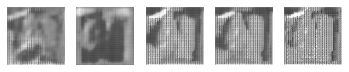

10, 1/53, d=0.000, g=11.062
10, 2/53, d=0.000, g=10.960
10, 3/53, d=0.000, g=10.999
10, 4/53, d=0.000, g=10.938
10, 5/53, d=0.000, g=10.981
10, 6/53, d=0.000, g=10.857
10, 7/53, d=0.000, g=11.021
10, 8/53, d=0.000, g=10.953
10, 9/53, d=0.000, g=10.852
10, 10/53, d=0.000, g=10.797
10, 11/53, d=0.000, g=10.841
10, 12/53, d=0.000, g=10.987
10, 13/53, d=0.000, g=10.813
10, 14/53, d=0.000, g=11.086
10, 15/53, d=0.000, g=10.979
10, 16/53, d=0.000, g=11.062
10, 17/53, d=0.000, g=11.009
10, 18/53, d=0.000, g=10.940
10, 19/53, d=0.000, g=10.675
10, 20/53, d=0.000, g=10.943
10, 21/53, d=0.000, g=10.847
10, 22/53, d=0.000, g=10.778
10, 23/53, d=0.000, g=11.040
10, 24/53, d=0.000, g=11.024
10, 25/53, d=0.000, g=10.866
10, 26/53, d=0.000, g=10.766
10, 27/53, d=0.000, g=11.070
10, 28/53, d=0.000, g=10.883
10, 29/53, d=0.000, g=11.159
10, 30/53, d=0.000, g=10.821
10, 31/53, d=0.000, g=10.795
10, 32/53, d=0.000, g=10.884
10, 33/53, d=0.000, g=10.762
10, 34/53, d=0.000, g=10.898
10, 35/53, d=0.000, g=1

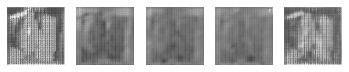

Accuracy real: 100%, fake: 100%
11, 1/53, d=0.000, g=11.067
11, 2/53, d=0.000, g=11.229
11, 3/53, d=0.000, g=11.396
11, 4/53, d=0.000, g=11.512
11, 5/53, d=0.000, g=11.214
11, 6/53, d=0.000, g=11.388
11, 7/53, d=0.000, g=11.271
11, 8/53, d=0.000, g=11.660
11, 9/53, d=0.000, g=11.373
11, 10/53, d=0.000, g=11.509
11, 11/53, d=0.000, g=11.230
11, 12/53, d=0.000, g=11.385
11, 13/53, d=0.000, g=11.446
11, 14/53, d=0.000, g=11.040
11, 15/53, d=0.000, g=11.285
11, 16/53, d=0.000, g=11.357
11, 17/53, d=0.000, g=11.605
11, 18/53, d=0.539, g=9.112
11, 19/53, d=0.000, g=7.941
11, 20/53, d=0.001, g=7.942
11, 21/53, d=0.001, g=8.517
11, 22/53, d=0.001, g=8.386
11, 23/53, d=0.000, g=9.279
11, 24/53, d=0.000, g=9.303
11, 25/53, d=0.000, g=8.981
11, 26/53, d=0.000, g=8.836
11, 27/53, d=0.000, g=9.166
11, 28/53, d=0.000, g=9.239
11, 29/53, d=0.000, g=9.196
11, 30/53, d=0.000, g=9.360
11, 31/53, d=0.000, g=9.175
11, 32/53, d=0.000, g=9.641
11, 33/53, d=0.000, g=9.371
11, 34/53, d=0.000, g=9.313
11, 35/5

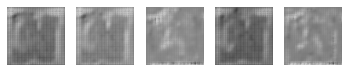

12, 1/53, d=0.000, g=9.968
12, 2/53, d=0.000, g=9.810
12, 3/53, d=0.000, g=10.029
12, 4/53, d=0.000, g=9.726
12, 5/53, d=0.000, g=10.052
12, 6/53, d=0.000, g=9.819
12, 7/53, d=0.000, g=10.082
12, 8/53, d=0.000, g=10.020
12, 9/53, d=0.000, g=9.756
12, 10/53, d=0.000, g=10.005
12, 11/53, d=0.000, g=10.206
12, 12/53, d=0.001, g=9.965
12, 13/53, d=0.000, g=10.024
12, 14/53, d=0.000, g=10.153
12, 15/53, d=0.000, g=10.288
12, 16/53, d=0.000, g=10.160
12, 17/53, d=0.000, g=10.595
12, 18/53, d=0.000, g=10.372
12, 19/53, d=0.000, g=10.065
12, 20/53, d=0.000, g=10.458
12, 21/53, d=0.000, g=10.583
12, 22/53, d=0.000, g=10.235
12, 23/53, d=0.000, g=10.497
12, 24/53, d=0.000, g=10.267
12, 25/53, d=0.000, g=10.069
12, 26/53, d=0.000, g=10.401
12, 27/53, d=0.000, g=10.427
12, 28/53, d=0.000, g=10.665
12, 29/53, d=0.000, g=10.492
12, 30/53, d=0.000, g=10.503
12, 31/53, d=0.000, g=10.630
12, 32/53, d=0.000, g=10.472
12, 33/53, d=0.000, g=10.236
12, 34/53, d=0.000, g=10.575
12, 35/53, d=0.000, g=10.465


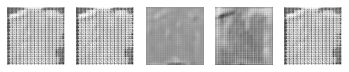

13, 1/53, d=0.000, g=10.436
13, 2/53, d=0.000, g=10.447
13, 3/53, d=0.000, g=10.332
13, 4/53, d=0.000, g=10.566
13, 5/53, d=0.000, g=10.202
13, 6/53, d=0.000, g=10.233
13, 7/53, d=0.000, g=10.274
13, 8/53, d=0.000, g=10.672
13, 9/53, d=0.000, g=10.800
13, 10/53, d=0.000, g=10.310
13, 11/53, d=0.000, g=10.517
13, 12/53, d=0.000, g=10.560
13, 13/53, d=0.000, g=10.330
13, 14/53, d=0.000, g=10.642
13, 15/53, d=0.000, g=10.622
13, 16/53, d=0.000, g=10.319
13, 17/53, d=0.000, g=10.449
13, 18/53, d=0.000, g=10.353
13, 19/53, d=0.000, g=10.562
13, 20/53, d=0.000, g=10.619
13, 21/53, d=0.000, g=10.361
13, 22/53, d=0.000, g=10.385
13, 23/53, d=0.000, g=10.623
13, 24/53, d=0.000, g=10.430
13, 25/53, d=0.000, g=10.067
13, 26/53, d=0.000, g=10.454
13, 27/53, d=0.000, g=10.531
13, 28/53, d=0.000, g=10.391
13, 29/53, d=0.000, g=10.440
13, 30/53, d=0.000, g=10.375
13, 31/53, d=0.000, g=10.606
13, 32/53, d=0.000, g=10.573
13, 33/53, d=0.000, g=10.596
13, 34/53, d=0.000, g=10.391
13, 35/53, d=0.000, g=1

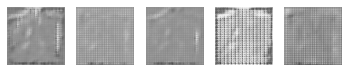

14, 1/53, d=0.000, g=10.292
14, 2/53, d=0.000, g=10.600
14, 3/53, d=0.000, g=10.295
14, 4/53, d=0.000, g=10.561
14, 5/53, d=0.000, g=10.334
14, 6/53, d=0.000, g=10.701
14, 7/53, d=0.000, g=10.698
14, 8/53, d=0.000, g=10.509
14, 9/53, d=0.000, g=10.585
14, 10/53, d=0.000, g=10.221
14, 11/53, d=0.000, g=10.235
14, 12/53, d=0.000, g=10.594
14, 13/53, d=0.000, g=10.270
14, 14/53, d=0.000, g=10.467
14, 15/53, d=0.000, g=10.684
14, 16/53, d=0.000, g=10.849
14, 17/53, d=0.000, g=10.704
14, 18/53, d=0.000, g=10.719
14, 19/53, d=0.000, g=10.600
14, 20/53, d=0.000, g=10.255
14, 21/53, d=0.000, g=10.533
14, 22/53, d=0.000, g=10.540
14, 23/53, d=0.000, g=10.463
14, 24/53, d=0.000, g=10.579
14, 25/53, d=0.000, g=10.474
14, 26/53, d=0.000, g=10.413
14, 27/53, d=0.000, g=10.814
14, 28/53, d=0.000, g=10.655
14, 29/53, d=0.000, g=10.410
14, 30/53, d=0.000, g=10.438
14, 31/53, d=0.000, g=10.468
14, 32/53, d=0.000, g=10.448
14, 33/53, d=0.000, g=10.527
14, 34/53, d=0.000, g=10.376
14, 35/53, d=0.000, g=1

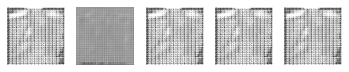

15, 1/53, d=0.000, g=10.727
15, 2/53, d=0.000, g=10.791
15, 3/53, d=0.000, g=11.029
15, 4/53, d=0.000, g=10.441
15, 5/53, d=0.000, g=10.777
15, 6/53, d=0.000, g=10.475
15, 7/53, d=0.000, g=10.743
15, 8/53, d=0.000, g=10.831
15, 9/53, d=0.000, g=10.950
15, 10/53, d=0.000, g=10.999
15, 11/53, d=0.000, g=10.760
15, 12/53, d=0.000, g=10.591
15, 13/53, d=0.000, g=10.549
15, 14/53, d=0.000, g=10.633
15, 15/53, d=0.000, g=10.761
15, 16/53, d=0.000, g=11.146
15, 17/53, d=0.000, g=10.564
15, 18/53, d=0.000, g=10.748
15, 19/53, d=0.000, g=10.688
15, 20/53, d=0.000, g=10.658
15, 21/53, d=0.000, g=10.461
15, 22/53, d=0.000, g=10.309
15, 23/53, d=0.000, g=10.539
15, 24/53, d=0.000, g=10.984
15, 25/53, d=0.000, g=11.442
15, 26/53, d=0.000, g=10.504
15, 27/53, d=0.000, g=9.877
15, 28/53, d=0.000, g=10.019
15, 29/53, d=0.000, g=10.295
15, 30/53, d=0.000, g=10.680
15, 31/53, d=0.000, g=10.167
15, 32/53, d=0.000, g=9.604
15, 33/53, d=0.000, g=10.074
15, 34/53, d=0.000, g=10.346
15, 35/53, d=0.000, g=10.

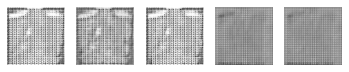

16, 1/53, d=0.000, g=11.125
16, 2/53, d=0.000, g=10.803
16, 3/53, d=0.000, g=10.844
16, 4/53, d=0.000, g=10.679
16, 5/53, d=0.000, g=10.799
16, 6/53, d=0.000, g=10.845
16, 7/53, d=0.000, g=10.769
16, 8/53, d=0.000, g=11.117
16, 9/53, d=0.000, g=11.415
16, 10/53, d=0.000, g=10.891
16, 11/53, d=0.000, g=11.285
16, 12/53, d=0.000, g=11.475
16, 13/53, d=0.000, g=10.818
16, 14/53, d=0.000, g=10.775
16, 15/53, d=0.000, g=10.995
16, 16/53, d=0.000, g=10.819
16, 17/53, d=0.000, g=11.185
16, 18/53, d=0.000, g=10.819
16, 19/53, d=0.000, g=10.722
16, 20/53, d=0.000, g=11.202
16, 21/53, d=0.000, g=11.033
16, 22/53, d=0.000, g=10.947
16, 23/53, d=0.000, g=11.082
16, 24/53, d=0.000, g=11.037
16, 25/53, d=0.000, g=10.996
16, 26/53, d=0.000, g=10.793
16, 27/53, d=0.000, g=11.144
16, 28/53, d=0.000, g=10.984
16, 29/53, d=0.000, g=10.816
16, 30/53, d=0.000, g=11.188
16, 31/53, d=0.000, g=11.074
16, 32/53, d=0.000, g=11.170
16, 33/53, d=0.000, g=11.105
16, 34/53, d=0.000, g=11.180
16, 35/53, d=0.000, g=1

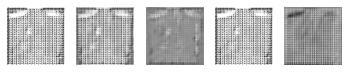

17, 1/53, d=0.000, g=11.288
17, 2/53, d=0.000, g=11.107
17, 3/53, d=0.000, g=11.241
17, 4/53, d=0.000, g=11.321
17, 5/53, d=0.000, g=10.947
17, 6/53, d=0.000, g=11.248
17, 7/53, d=0.000, g=11.090
17, 8/53, d=0.000, g=11.570
17, 9/53, d=0.000, g=11.583
17, 10/53, d=0.000, g=11.492
17, 11/53, d=0.000, g=11.261
17, 12/53, d=0.000, g=11.287
17, 13/53, d=0.000, g=11.198
17, 14/53, d=0.000, g=11.079
17, 15/53, d=0.000, g=11.102
17, 16/53, d=0.000, g=11.154
17, 17/53, d=0.000, g=11.552
17, 18/53, d=0.000, g=11.152
17, 19/53, d=0.000, g=12.207
17, 20/53, d=0.000, g=11.329
17, 21/53, d=0.000, g=11.269
17, 22/53, d=0.000, g=11.363
17, 23/53, d=0.000, g=11.130
17, 24/53, d=0.000, g=11.295
17, 25/53, d=0.000, g=11.279
17, 26/53, d=0.000, g=11.035
17, 27/53, d=0.000, g=10.957
17, 28/53, d=0.000, g=11.427
17, 29/53, d=0.000, g=11.386
17, 30/53, d=0.000, g=11.285
17, 31/53, d=0.000, g=10.983
17, 32/53, d=0.000, g=11.114
17, 33/53, d=0.000, g=11.506
17, 34/53, d=0.000, g=11.138
17, 35/53, d=0.000, g=1

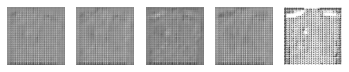

18, 1/53, d=0.000, g=11.330
18, 2/53, d=0.000, g=11.348
18, 3/53, d=0.000, g=11.530
18, 4/53, d=0.000, g=11.185
18, 5/53, d=0.000, g=11.289
18, 6/53, d=0.000, g=11.145
18, 7/53, d=0.000, g=11.422
18, 8/53, d=0.000, g=11.770
18, 9/53, d=0.000, g=11.713
18, 10/53, d=0.000, g=11.394
18, 11/53, d=0.000, g=11.728
18, 12/53, d=0.000, g=11.809
18, 13/53, d=0.000, g=11.421
18, 14/53, d=0.000, g=11.546
18, 15/53, d=0.000, g=11.646
18, 16/53, d=0.000, g=11.299
18, 17/53, d=0.000, g=11.234
18, 18/53, d=0.000, g=11.126
18, 19/53, d=0.000, g=11.077
18, 20/53, d=0.000, g=11.268
18, 21/53, d=0.000, g=11.661
18, 22/53, d=0.000, g=11.246
18, 23/53, d=0.000, g=11.193
18, 24/53, d=0.000, g=11.356
18, 25/53, d=0.000, g=11.178
18, 26/53, d=0.000, g=11.153
18, 27/53, d=0.000, g=10.955
18, 28/53, d=0.000, g=11.349
18, 29/53, d=0.000, g=11.425
18, 30/53, d=0.000, g=11.339
18, 31/53, d=0.000, g=11.415
18, 32/53, d=0.000, g=11.527
18, 33/53, d=0.000, g=11.308
18, 34/53, d=0.000, g=11.561
18, 35/53, d=0.000, g=1

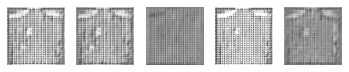

19, 1/53, d=0.000, g=11.793
19, 2/53, d=0.000, g=11.529
19, 3/53, d=0.000, g=11.408
19, 4/53, d=0.000, g=11.173
19, 5/53, d=0.000, g=11.147
19, 6/53, d=0.000, g=11.390
19, 7/53, d=0.000, g=11.295
19, 8/53, d=0.000, g=11.626
19, 9/53, d=0.000, g=11.589
19, 10/53, d=0.000, g=11.270
19, 11/53, d=0.000, g=11.253
19, 12/53, d=0.000, g=11.425
19, 13/53, d=0.000, g=11.226
19, 14/53, d=0.000, g=11.067
19, 15/53, d=0.000, g=11.176
19, 16/53, d=0.000, g=11.289
19, 17/53, d=0.000, g=11.161
19, 18/53, d=0.000, g=11.173
19, 19/53, d=0.000, g=11.548
19, 20/53, d=0.000, g=11.179
19, 21/53, d=0.000, g=11.242
19, 22/53, d=0.000, g=11.260
19, 23/53, d=0.000, g=11.358
19, 24/53, d=0.000, g=11.432
19, 25/53, d=0.000, g=11.072
19, 26/53, d=0.000, g=11.418
19, 27/53, d=0.000, g=11.240
19, 28/53, d=0.000, g=11.319
19, 29/53, d=0.000, g=11.487
19, 30/53, d=0.000, g=11.364
19, 31/53, d=0.000, g=11.145
19, 32/53, d=0.000, g=11.402
19, 33/53, d=0.000, g=11.450
19, 34/53, d=0.000, g=11.540
19, 35/53, d=0.000, g=1

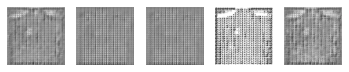

20, 1/53, d=0.000, g=11.408
20, 2/53, d=0.000, g=11.297
20, 3/53, d=0.000, g=11.139
20, 4/53, d=0.000, g=11.492
20, 5/53, d=0.000, g=11.251
20, 6/53, d=0.000, g=11.297
20, 7/53, d=0.000, g=11.294
20, 8/53, d=0.000, g=11.979
20, 9/53, d=0.000, g=11.544
20, 10/53, d=0.000, g=11.644
20, 11/53, d=0.000, g=11.388
20, 12/53, d=0.000, g=11.178
20, 13/53, d=0.000, g=11.418
20, 14/53, d=0.000, g=11.243
20, 15/53, d=0.000, g=11.470
20, 16/53, d=0.000, g=11.449
20, 17/53, d=0.000, g=11.543
20, 18/53, d=0.000, g=11.628
20, 19/53, d=0.000, g=11.778
20, 20/53, d=0.000, g=11.872
20, 21/53, d=0.000, g=11.220
20, 22/53, d=0.000, g=11.639
20, 23/53, d=0.000, g=11.889
20, 24/53, d=0.000, g=11.474
20, 25/53, d=0.000, g=11.610
20, 26/53, d=0.000, g=11.369
20, 27/53, d=0.000, g=11.349
20, 28/53, d=0.000, g=11.572
20, 29/53, d=0.000, g=11.611
20, 30/53, d=0.000, g=11.550
20, 31/53, d=0.000, g=11.448
20, 32/53, d=0.000, g=11.273
20, 33/53, d=0.000, g=11.242
20, 34/53, d=0.000, g=11.379
20, 35/53, d=0.000, g=1

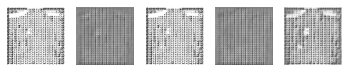

Accuracy real: 100%, fake: 100%
21, 1/53, d=0.000, g=11.868
21, 2/53, d=0.000, g=11.411
21, 3/53, d=0.000, g=11.481
21, 4/53, d=0.000, g=11.618
21, 5/53, d=0.000, g=11.499
21, 6/53, d=0.000, g=11.426
21, 7/53, d=0.000, g=11.559
21, 8/53, d=0.000, g=11.720
21, 9/53, d=0.000, g=11.906
21, 10/53, d=0.000, g=11.588
21, 11/53, d=0.000, g=11.602
21, 12/53, d=0.000, g=11.445
21, 13/53, d=0.000, g=11.421
21, 14/53, d=0.000, g=11.541
21, 15/53, d=0.000, g=11.532
21, 16/53, d=0.000, g=11.429
21, 17/53, d=0.000, g=11.658
21, 18/53, d=0.000, g=11.631
21, 19/53, d=0.000, g=11.616
21, 20/53, d=0.000, g=11.663
21, 21/53, d=0.000, g=11.339
21, 22/53, d=0.000, g=11.305
21, 23/53, d=0.000, g=11.477
21, 24/53, d=0.000, g=11.465
21, 25/53, d=0.000, g=11.348
21, 26/53, d=0.000, g=11.318
21, 27/53, d=0.000, g=11.354
21, 28/53, d=0.000, g=11.347
21, 29/53, d=0.000, g=11.435
21, 30/53, d=0.000, g=11.465
21, 31/53, d=0.000, g=11.598
21, 32/53, d=0.000, g=11.794
21, 33/53, d=0.000, g=11.675
21, 34/53, d=0.000, 

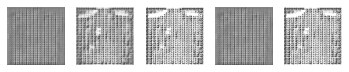

22, 1/53, d=0.000, g=11.620
22, 2/53, d=0.000, g=11.469
22, 3/53, d=0.000, g=11.460
22, 4/53, d=0.000, g=11.703
22, 5/53, d=0.000, g=11.420
22, 6/53, d=0.000, g=11.333
22, 7/53, d=0.000, g=11.480
22, 8/53, d=0.000, g=11.390
22, 9/53, d=0.000, g=11.286
22, 10/53, d=0.000, g=11.395
22, 11/53, d=0.000, g=11.440
22, 12/53, d=0.000, g=11.371
22, 13/53, d=0.000, g=11.754
22, 14/53, d=0.000, g=11.458
22, 15/53, d=0.000, g=11.439
22, 16/53, d=0.000, g=11.612
22, 17/53, d=0.000, g=11.810
22, 18/53, d=0.000, g=11.704
22, 19/53, d=0.000, g=12.064
22, 20/53, d=0.000, g=11.521
22, 21/53, d=0.000, g=11.587
22, 22/53, d=0.000, g=11.885
22, 23/53, d=0.000, g=11.726
22, 24/53, d=0.000, g=11.454
22, 25/53, d=0.000, g=11.872
22, 26/53, d=0.000, g=11.841
22, 27/53, d=0.000, g=11.611
22, 28/53, d=0.000, g=11.408
22, 29/53, d=0.000, g=11.378
22, 30/53, d=0.000, g=11.537
22, 31/53, d=0.000, g=11.757
22, 32/53, d=0.000, g=11.497
22, 33/53, d=0.000, g=11.594
22, 34/53, d=0.000, g=11.775
22, 35/53, d=0.000, g=1

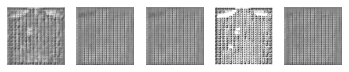

23, 1/53, d=0.000, g=11.562
23, 2/53, d=0.000, g=11.841
23, 3/53, d=0.000, g=12.092
23, 4/53, d=0.000, g=12.624
23, 5/53, d=0.000, g=11.902
23, 6/53, d=0.000, g=12.197
23, 7/53, d=0.000, g=11.934
23, 8/53, d=0.000, g=11.587
23, 9/53, d=0.000, g=11.856
23, 10/53, d=0.000, g=11.558
23, 11/53, d=0.000, g=11.590
23, 12/53, d=0.000, g=11.749
23, 13/53, d=0.000, g=11.679
23, 14/53, d=0.000, g=11.462
23, 15/53, d=0.000, g=11.782
23, 16/53, d=0.000, g=11.851
23, 17/53, d=0.000, g=11.703
23, 18/53, d=0.000, g=11.631
23, 19/53, d=0.000, g=11.447
23, 20/53, d=0.000, g=11.555
23, 21/53, d=0.000, g=11.638
23, 22/53, d=0.000, g=11.568
23, 23/53, d=0.000, g=11.801
23, 24/53, d=0.000, g=11.699
23, 25/53, d=0.000, g=11.609
23, 26/53, d=0.000, g=11.941
23, 27/53, d=0.000, g=11.668
23, 28/53, d=0.000, g=11.617
23, 29/53, d=0.000, g=11.782
23, 30/53, d=0.000, g=11.883
23, 31/53, d=0.000, g=12.040
23, 32/53, d=0.000, g=11.943
23, 33/53, d=0.000, g=11.615
23, 34/53, d=0.000, g=11.706
23, 35/53, d=0.000, g=1

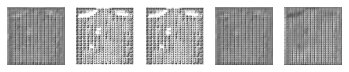

24, 1/53, d=0.000, g=11.761
24, 2/53, d=0.000, g=11.900
24, 3/53, d=0.000, g=11.526
24, 4/53, d=0.000, g=11.763
24, 5/53, d=0.000, g=11.744
24, 6/53, d=0.000, g=11.901
24, 7/53, d=0.000, g=11.893
24, 8/53, d=0.000, g=12.058
24, 9/53, d=0.000, g=11.693
24, 10/53, d=0.000, g=11.878
24, 11/53, d=0.000, g=11.828
24, 12/53, d=0.000, g=11.812
24, 13/53, d=0.000, g=11.856
24, 14/53, d=0.000, g=11.933
24, 15/53, d=0.000, g=11.772
24, 16/53, d=0.000, g=11.878
24, 17/53, d=0.000, g=11.728
24, 18/53, d=0.000, g=11.705
24, 19/53, d=0.000, g=11.880
24, 20/53, d=0.000, g=12.256
24, 21/53, d=0.000, g=11.796
24, 22/53, d=0.000, g=11.947
24, 23/53, d=0.000, g=11.867
24, 24/53, d=0.000, g=12.140
24, 25/53, d=0.000, g=11.918
24, 26/53, d=0.000, g=11.804
24, 27/53, d=0.000, g=11.994
24, 28/53, d=0.000, g=11.976
24, 29/53, d=0.000, g=11.936
24, 30/53, d=0.000, g=12.007
24, 31/53, d=0.000, g=12.142
24, 32/53, d=0.000, g=12.037
24, 33/53, d=0.000, g=12.148
24, 34/53, d=0.000, g=11.986
24, 35/53, d=0.000, g=1

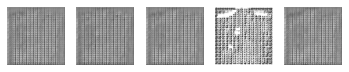

25, 1/53, d=0.000, g=12.123
25, 2/53, d=0.000, g=12.545
25, 3/53, d=0.000, g=12.190
25, 4/53, d=0.000, g=12.119
25, 5/53, d=0.000, g=12.300
25, 6/53, d=0.000, g=12.044
25, 7/53, d=0.000, g=12.011
25, 8/53, d=0.000, g=11.997
25, 9/53, d=0.000, g=12.077
25, 10/53, d=0.000, g=12.007
25, 11/53, d=0.000, g=11.775
25, 12/53, d=0.000, g=11.940
25, 13/53, d=0.000, g=11.987
25, 14/53, d=0.000, g=12.139
25, 15/53, d=0.000, g=11.875
25, 16/53, d=0.000, g=12.281
25, 17/53, d=0.000, g=12.001
25, 18/53, d=0.000, g=11.760
25, 19/53, d=0.000, g=12.360
25, 20/53, d=0.000, g=11.807
25, 21/53, d=0.000, g=12.228
25, 22/53, d=0.000, g=11.849
25, 23/53, d=0.000, g=12.098
25, 24/53, d=0.000, g=11.889
25, 25/53, d=0.000, g=11.949
25, 26/53, d=0.000, g=11.854
25, 27/53, d=0.000, g=12.007
25, 28/53, d=0.000, g=12.076
25, 29/53, d=0.000, g=12.263
25, 30/53, d=0.000, g=11.935
25, 31/53, d=0.000, g=12.125
25, 32/53, d=0.000, g=11.831
25, 33/53, d=0.000, g=11.994
25, 34/53, d=0.000, g=12.124
25, 35/53, d=0.000, g=1

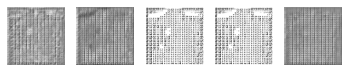

26, 1/53, d=0.336, g=16.121
26, 2/53, d=0.000, g=15.402
26, 3/53, d=0.009, g=11.163
26, 4/53, d=1.931, g=15.651
26, 5/53, d=0.005, g=17.611
26, 6/53, d=0.000, g=19.997
26, 7/53, d=0.000, g=21.886
26, 8/53, d=0.000, g=22.192
26, 9/53, d=0.000, g=21.926
26, 10/53, d=0.000, g=22.171
26, 11/53, d=0.000, g=21.783
26, 12/53, d=0.000, g=22.511
26, 13/53, d=0.000, g=22.071
26, 14/53, d=0.000, g=21.141
26, 15/53, d=0.000, g=20.820
26, 16/53, d=0.000, g=20.317
26, 17/53, d=0.000, g=20.343
26, 18/53, d=0.000, g=21.280
26, 19/53, d=0.000, g=19.594
26, 20/53, d=0.000, g=20.474
26, 21/53, d=0.000, g=20.472
26, 22/53, d=0.000, g=19.186
26, 23/53, d=0.000, g=19.976
26, 24/53, d=0.000, g=19.326
26, 25/53, d=0.000, g=19.993
26, 26/53, d=0.000, g=19.363
26, 27/53, d=0.000, g=18.937
26, 28/53, d=0.000, g=18.976
26, 29/53, d=0.000, g=18.793
26, 30/53, d=0.000, g=19.236
26, 31/53, d=0.000, g=19.274
26, 32/53, d=0.000, g=19.310
26, 33/53, d=0.000, g=19.544
26, 34/53, d=0.000, g=18.504
26, 35/53, d=0.000, g=1

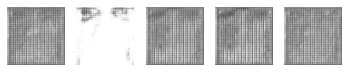

27, 1/53, d=0.000, g=10.310
27, 2/53, d=0.000, g=10.254
27, 3/53, d=0.001, g=10.315
27, 4/53, d=0.000, g=10.283
27, 5/53, d=0.000, g=10.153
27, 6/53, d=0.000, g=10.219
27, 7/53, d=0.000, g=10.115
27, 8/53, d=0.000, g=10.169
27, 9/53, d=0.000, g=9.830
27, 10/53, d=0.000, g=10.177
27, 11/53, d=0.000, g=10.253
27, 12/53, d=0.000, g=9.923
27, 13/53, d=0.000, g=10.122
27, 14/53, d=0.000, g=9.951
27, 15/53, d=0.000, g=9.986
27, 16/53, d=0.000, g=10.040
27, 17/53, d=0.000, g=9.794
27, 18/53, d=0.000, g=9.989
27, 19/53, d=0.000, g=9.807
27, 20/53, d=0.000, g=9.810
27, 21/53, d=0.000, g=9.850
27, 22/53, d=0.000, g=9.933
27, 23/53, d=0.000, g=9.645
27, 24/53, d=0.000, g=9.742
27, 25/53, d=0.000, g=9.962
27, 26/53, d=0.000, g=9.743
27, 27/53, d=0.000, g=9.542
27, 28/53, d=0.000, g=9.802
27, 29/53, d=0.000, g=10.057
27, 30/53, d=0.000, g=10.002
27, 31/53, d=0.000, g=9.992
27, 32/53, d=0.000, g=9.775
27, 33/53, d=0.000, g=9.884
27, 34/53, d=0.000, g=10.032
27, 35/53, d=0.000, g=9.879
27, 36/53, d=0

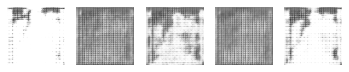

28, 1/53, d=0.000, g=10.115
28, 2/53, d=0.000, g=10.070
28, 3/53, d=0.000, g=9.975
28, 4/53, d=0.000, g=10.081
28, 5/53, d=0.000, g=9.916
28, 6/53, d=0.000, g=9.888
28, 7/53, d=0.000, g=9.883
28, 8/53, d=0.000, g=9.789
28, 9/53, d=0.000, g=10.162
28, 10/53, d=0.000, g=9.756
28, 11/53, d=0.000, g=10.005
28, 12/53, d=0.000, g=10.121
28, 13/53, d=0.000, g=9.909
28, 14/53, d=0.000, g=9.871
28, 15/53, d=0.000, g=9.912
28, 16/53, d=0.000, g=10.043
28, 17/53, d=0.000, g=10.401
28, 18/53, d=0.000, g=9.975
28, 19/53, d=0.000, g=10.221
28, 20/53, d=0.000, g=10.059
28, 21/53, d=0.000, g=9.733
28, 22/53, d=0.000, g=10.066
28, 23/53, d=0.000, g=9.723
28, 24/53, d=0.000, g=10.051
28, 25/53, d=0.000, g=10.095
28, 26/53, d=0.000, g=10.170
28, 27/53, d=0.000, g=10.164
28, 28/53, d=0.000, g=10.179
28, 29/53, d=0.000, g=10.319
28, 30/53, d=0.000, g=10.399
28, 31/53, d=0.000, g=10.213
28, 32/53, d=0.000, g=10.140
28, 33/53, d=0.000, g=10.401
28, 34/53, d=0.000, g=10.334
28, 35/53, d=0.000, g=10.091
28, 36

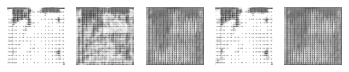

29, 1/53, d=0.000, g=10.507
29, 2/53, d=0.000, g=10.452
29, 3/53, d=0.000, g=10.559
29, 4/53, d=0.000, g=10.442
29, 5/53, d=0.000, g=10.782
29, 6/53, d=0.000, g=10.470
29, 7/53, d=0.000, g=10.277
29, 8/53, d=0.000, g=10.522
29, 9/53, d=0.000, g=10.418
29, 10/53, d=0.000, g=10.695
29, 11/53, d=0.000, g=10.723
29, 12/53, d=0.000, g=10.606
29, 13/53, d=0.000, g=10.495
29, 14/53, d=0.000, g=10.478
29, 15/53, d=0.000, g=10.475
29, 16/53, d=0.000, g=10.485
29, 17/53, d=0.000, g=10.638
29, 18/53, d=0.000, g=10.621
29, 19/53, d=0.000, g=10.563
29, 20/53, d=0.000, g=10.562
29, 21/53, d=0.000, g=10.479
29, 22/53, d=0.000, g=10.604
29, 23/53, d=0.000, g=10.231
29, 24/53, d=0.000, g=10.611
29, 25/53, d=0.000, g=10.488
29, 26/53, d=0.000, g=10.577
29, 27/53, d=0.000, g=10.754
29, 28/53, d=0.000, g=10.508
29, 29/53, d=0.000, g=10.852
29, 30/53, d=0.000, g=10.643
29, 31/53, d=0.000, g=10.369
29, 32/53, d=0.000, g=10.375
29, 33/53, d=0.000, g=10.784
29, 34/53, d=0.000, g=10.642
29, 35/53, d=0.000, g=1

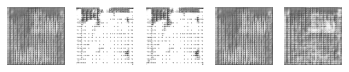

30, 1/53, d=0.000, g=10.864
30, 2/53, d=0.000, g=10.619
30, 3/53, d=0.000, g=10.654
30, 4/53, d=0.000, g=10.799
30, 5/53, d=0.000, g=10.604
30, 6/53, d=0.000, g=10.806
30, 7/53, d=0.000, g=10.780
30, 8/53, d=0.000, g=10.937
30, 9/53, d=0.000, g=10.813
30, 10/53, d=0.000, g=10.684
30, 11/53, d=0.000, g=10.900
30, 12/53, d=0.000, g=10.991
30, 13/53, d=0.000, g=10.826
30, 14/53, d=0.000, g=10.620
30, 15/53, d=0.000, g=10.831
30, 16/53, d=0.000, g=10.567
30, 17/53, d=0.000, g=10.777
30, 18/53, d=0.000, g=10.856
30, 19/53, d=0.000, g=10.761
30, 20/53, d=0.000, g=10.829
30, 21/53, d=0.000, g=10.858
30, 22/53, d=0.000, g=10.779
30, 23/53, d=0.000, g=10.943
30, 24/53, d=0.000, g=10.829
30, 25/53, d=0.000, g=10.945
30, 26/53, d=0.000, g=10.768
30, 27/53, d=0.000, g=10.747
30, 28/53, d=0.000, g=10.934
30, 29/53, d=0.000, g=10.820
30, 30/53, d=0.000, g=10.578
30, 31/53, d=0.000, g=10.844
30, 32/53, d=0.000, g=10.887
30, 33/53, d=0.000, g=10.798
30, 34/53, d=0.000, g=10.809
30, 35/53, d=0.000, g=1

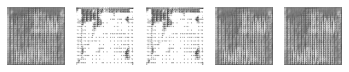

Accuracy real: 100%, fake: 100%
31, 1/53, d=0.000, g=11.090
31, 2/53, d=0.000, g=11.097
31, 3/53, d=0.000, g=10.974
31, 4/53, d=0.000, g=10.995
31, 5/53, d=0.000, g=11.248
31, 6/53, d=0.000, g=11.112
31, 7/53, d=0.000, g=11.038
31, 8/53, d=0.000, g=11.053
31, 9/53, d=0.000, g=10.956
31, 10/53, d=0.000, g=11.233
31, 11/53, d=0.000, g=10.952
31, 12/53, d=0.000, g=10.631
31, 13/53, d=0.000, g=10.916
31, 14/53, d=0.000, g=10.979
31, 15/53, d=0.000, g=11.362
31, 16/53, d=0.000, g=11.053
31, 17/53, d=0.000, g=10.908
31, 18/53, d=0.000, g=11.271
31, 19/53, d=0.000, g=10.951
31, 20/53, d=0.000, g=11.198
31, 21/53, d=0.000, g=11.165
31, 22/53, d=0.000, g=11.150
31, 23/53, d=0.000, g=11.268
31, 24/53, d=0.000, g=11.156
31, 25/53, d=0.000, g=11.029
31, 26/53, d=0.000, g=11.186
31, 27/53, d=0.000, g=10.917
31, 28/53, d=0.000, g=11.230
31, 29/53, d=0.000, g=10.965
31, 30/53, d=0.000, g=11.129
31, 31/53, d=0.000, g=11.190
31, 32/53, d=0.000, g=11.149
31, 33/53, d=0.000, g=11.182
31, 34/53, d=0.000, 

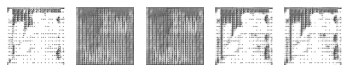

32, 1/53, d=0.000, g=11.147
32, 2/53, d=0.000, g=11.129
32, 3/53, d=0.000, g=11.250
32, 4/53, d=0.000, g=11.332
32, 5/53, d=0.000, g=11.296
32, 6/53, d=0.000, g=11.461
32, 7/53, d=0.000, g=11.114
32, 8/53, d=0.000, g=11.437
32, 9/53, d=0.000, g=11.244
32, 10/53, d=0.000, g=11.336
32, 11/53, d=0.000, g=11.241
32, 12/53, d=0.000, g=11.313
32, 13/53, d=0.000, g=11.297
32, 14/53, d=0.000, g=11.400
32, 15/53, d=0.000, g=11.137
32, 16/53, d=0.000, g=11.214
32, 17/53, d=0.000, g=11.237
32, 18/53, d=0.000, g=11.492
32, 19/53, d=0.000, g=11.283
32, 20/53, d=0.000, g=11.420
32, 21/53, d=0.000, g=11.349
32, 22/53, d=0.000, g=11.159
32, 23/53, d=0.000, g=11.245
32, 24/53, d=0.000, g=11.301
32, 25/53, d=0.000, g=11.275
32, 26/53, d=0.000, g=11.342
32, 27/53, d=0.000, g=11.302
32, 28/53, d=0.000, g=11.292
32, 29/53, d=0.000, g=11.330
32, 30/53, d=0.000, g=11.221
32, 31/53, d=0.000, g=11.463
32, 32/53, d=0.000, g=11.345
32, 33/53, d=0.000, g=11.482
32, 34/53, d=0.000, g=11.338
32, 35/53, d=0.000, g=1

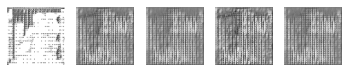

33, 1/53, d=0.000, g=11.590
33, 2/53, d=0.000, g=11.481
33, 3/53, d=0.000, g=11.670
33, 4/53, d=0.000, g=11.250
33, 5/53, d=0.000, g=11.354
33, 6/53, d=0.000, g=11.491
33, 7/53, d=0.000, g=11.443
33, 8/53, d=0.000, g=11.203
33, 9/53, d=0.000, g=11.513
33, 10/53, d=0.000, g=11.463
33, 11/53, d=0.000, g=11.348
33, 12/53, d=0.000, g=11.438
33, 13/53, d=0.000, g=11.507
33, 14/53, d=0.000, g=11.383
33, 15/53, d=0.000, g=11.427
33, 16/53, d=0.000, g=11.671
33, 17/53, d=0.000, g=11.466
33, 18/53, d=0.000, g=11.627
33, 19/53, d=0.000, g=11.730
33, 20/53, d=0.000, g=11.602
33, 21/53, d=0.000, g=11.657
33, 22/53, d=0.000, g=11.524
33, 23/53, d=0.000, g=11.617
33, 24/53, d=0.000, g=11.598
33, 25/53, d=0.000, g=11.539
33, 26/53, d=0.000, g=11.521
33, 27/53, d=0.000, g=11.471
33, 28/53, d=0.000, g=11.670
33, 29/53, d=0.000, g=11.458
33, 30/53, d=0.000, g=11.662
33, 31/53, d=0.000, g=11.825
33, 32/53, d=0.000, g=11.629
33, 33/53, d=0.000, g=11.512
33, 34/53, d=0.000, g=11.815
33, 35/53, d=0.000, g=1

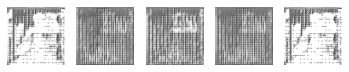

34, 1/53, d=0.000, g=11.709
34, 2/53, d=0.000, g=11.751
34, 3/53, d=0.000, g=11.659
34, 4/53, d=0.000, g=11.614
34, 5/53, d=0.000, g=11.694
34, 6/53, d=0.000, g=11.978
34, 7/53, d=0.000, g=11.895
34, 8/53, d=0.000, g=11.701
34, 9/53, d=0.000, g=11.513
34, 10/53, d=0.000, g=11.916
34, 11/53, d=0.000, g=11.822
34, 12/53, d=0.000, g=11.424
34, 13/53, d=0.000, g=11.807
34, 14/53, d=0.000, g=11.618
34, 15/53, d=0.000, g=11.820
34, 16/53, d=0.000, g=11.936
34, 17/53, d=0.000, g=11.647
34, 18/53, d=0.000, g=11.734
34, 19/53, d=0.000, g=11.853
34, 20/53, d=0.000, g=11.714
34, 21/53, d=0.000, g=11.906
34, 22/53, d=0.000, g=11.630
34, 23/53, d=0.000, g=11.754
34, 24/53, d=0.000, g=11.563
34, 25/53, d=0.000, g=11.842
34, 26/53, d=0.000, g=11.862
34, 27/53, d=0.000, g=11.817
34, 28/53, d=0.000, g=11.665
34, 29/53, d=0.000, g=11.876
34, 30/53, d=0.000, g=11.694
34, 31/53, d=0.000, g=11.431
34, 32/53, d=0.000, g=11.832
34, 33/53, d=0.000, g=11.870
34, 34/53, d=0.000, g=11.832
34, 35/53, d=0.000, g=1

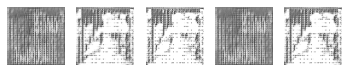

35, 1/53, d=0.000, g=11.506
35, 2/53, d=0.000, g=11.634
35, 3/53, d=0.000, g=11.756
35, 4/53, d=0.000, g=11.711
35, 5/53, d=0.000, g=12.102
35, 6/53, d=0.000, g=11.918
35, 7/53, d=0.000, g=11.806
35, 8/53, d=0.000, g=11.657
35, 9/53, d=0.000, g=11.645
35, 10/53, d=0.000, g=11.784
35, 11/53, d=0.000, g=11.821
35, 12/53, d=0.000, g=11.933
35, 13/53, d=0.000, g=11.619
35, 14/53, d=0.000, g=11.845
35, 15/53, d=0.000, g=11.792
35, 16/53, d=0.000, g=11.760
35, 17/53, d=0.000, g=11.790
35, 18/53, d=0.000, g=11.765
35, 19/53, d=0.000, g=11.675
35, 20/53, d=0.000, g=11.746
35, 21/53, d=0.000, g=11.700
35, 22/53, d=0.000, g=11.882
35, 23/53, d=0.000, g=11.651
35, 24/53, d=0.000, g=11.849
35, 25/53, d=0.000, g=11.691
35, 26/53, d=0.000, g=12.121
35, 27/53, d=0.000, g=11.795
35, 28/53, d=0.000, g=11.663
35, 29/53, d=0.000, g=12.078
35, 30/53, d=0.000, g=11.729
35, 31/53, d=0.000, g=12.013
35, 32/53, d=0.000, g=12.031
35, 33/53, d=0.000, g=12.100
35, 34/53, d=0.000, g=11.794
35, 35/53, d=0.000, g=1

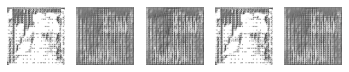

36, 1/53, d=0.000, g=11.881
36, 2/53, d=0.000, g=11.875
36, 3/53, d=0.000, g=12.206
36, 4/53, d=0.000, g=12.090
36, 5/53, d=0.000, g=11.808
36, 6/53, d=0.000, g=12.003
36, 7/53, d=0.000, g=11.932
36, 8/53, d=0.000, g=11.973
36, 9/53, d=0.000, g=11.935
36, 10/53, d=0.000, g=12.284
36, 11/53, d=0.000, g=12.174
36, 12/53, d=0.000, g=12.169
36, 13/53, d=0.000, g=12.038
36, 14/53, d=0.000, g=12.097
36, 15/53, d=0.000, g=11.868
36, 16/53, d=0.000, g=12.012
36, 17/53, d=0.000, g=12.102
36, 18/53, d=0.000, g=11.964
36, 19/53, d=0.000, g=11.958
36, 20/53, d=0.000, g=11.902
36, 21/53, d=0.000, g=11.919
36, 22/53, d=0.000, g=12.131
36, 23/53, d=0.000, g=12.052
36, 24/53, d=0.000, g=12.073
36, 25/53, d=0.000, g=12.002
36, 26/53, d=0.000, g=11.989
36, 27/53, d=0.000, g=12.002
36, 28/53, d=0.000, g=12.016
36, 29/53, d=0.000, g=12.158
36, 30/53, d=0.000, g=12.213
36, 31/53, d=0.000, g=12.225
36, 32/53, d=0.000, g=11.889
36, 33/53, d=0.000, g=11.980
36, 34/53, d=0.000, g=12.321
36, 35/53, d=0.000, g=1

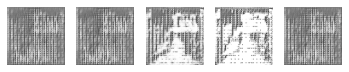

37, 1/53, d=0.000, g=11.918
37, 2/53, d=0.000, g=12.151
37, 3/53, d=0.000, g=12.001
37, 4/53, d=0.000, g=12.071
37, 5/53, d=0.000, g=12.245
37, 6/53, d=0.000, g=12.331
37, 7/53, d=0.000, g=12.142
37, 8/53, d=0.000, g=12.312
37, 9/53, d=0.000, g=12.061
37, 10/53, d=0.000, g=12.299
37, 11/53, d=0.000, g=12.241
37, 12/53, d=0.000, g=12.237
37, 13/53, d=0.000, g=12.144
37, 14/53, d=0.000, g=12.157
37, 15/53, d=0.000, g=12.318
37, 16/53, d=0.000, g=12.001
37, 17/53, d=0.000, g=12.348
37, 18/53, d=0.000, g=12.181
37, 19/53, d=0.000, g=12.315
37, 20/53, d=0.000, g=12.154
37, 21/53, d=0.000, g=12.150
37, 22/53, d=0.000, g=11.875
37, 23/53, d=0.000, g=12.349
37, 24/53, d=0.000, g=12.430
37, 25/53, d=0.000, g=12.446
37, 26/53, d=0.000, g=12.765
37, 27/53, d=0.000, g=12.263
37, 28/53, d=0.000, g=12.426
37, 29/53, d=0.000, g=12.456
37, 30/53, d=0.000, g=12.204
37, 31/53, d=0.000, g=12.387
37, 32/53, d=0.000, g=12.636
37, 33/53, d=0.000, g=12.194
37, 34/53, d=0.000, g=12.298
37, 35/53, d=0.000, g=1

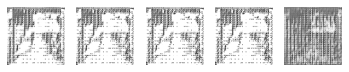

38, 1/53, d=0.000, g=12.396
38, 2/53, d=0.000, g=12.488
38, 3/53, d=0.000, g=12.204
38, 4/53, d=0.000, g=12.200
38, 5/53, d=0.000, g=12.198
38, 6/53, d=0.000, g=12.340
38, 7/53, d=0.000, g=12.646
38, 8/53, d=0.000, g=12.062
38, 9/53, d=0.000, g=12.053
38, 10/53, d=0.000, g=12.509
38, 11/53, d=0.000, g=12.425
38, 12/53, d=0.000, g=12.350
38, 13/53, d=0.000, g=12.154
38, 14/53, d=0.000, g=12.241
38, 15/53, d=0.000, g=12.514
38, 16/53, d=0.000, g=12.716
38, 17/53, d=0.000, g=12.626
38, 18/53, d=0.000, g=12.274
38, 19/53, d=0.000, g=12.283
38, 20/53, d=0.000, g=12.391
38, 21/53, d=0.000, g=12.150
38, 22/53, d=0.000, g=12.416
38, 23/53, d=0.000, g=12.287
38, 24/53, d=0.000, g=12.284
38, 25/53, d=0.000, g=12.193
38, 26/53, d=0.000, g=12.276
38, 27/53, d=0.000, g=12.432
38, 28/53, d=0.000, g=12.289
38, 29/53, d=0.000, g=12.388
38, 30/53, d=0.000, g=12.212
38, 31/53, d=0.000, g=12.456
38, 32/53, d=0.000, g=12.289
38, 33/53, d=0.000, g=12.431
38, 34/53, d=0.000, g=12.502
38, 35/53, d=0.000, g=1

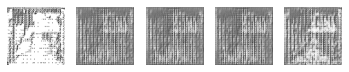

39, 1/53, d=0.000, g=12.348
39, 2/53, d=0.000, g=12.677
39, 3/53, d=0.000, g=12.632
39, 4/53, d=0.000, g=12.311
39, 5/53, d=0.000, g=12.654
39, 6/53, d=0.000, g=12.390
39, 7/53, d=0.000, g=12.580
39, 8/53, d=0.000, g=12.382
39, 9/53, d=0.000, g=12.647
39, 10/53, d=0.000, g=12.779
39, 11/53, d=0.000, g=12.490
39, 12/53, d=0.000, g=12.609
39, 13/53, d=0.000, g=12.317
39, 14/53, d=0.000, g=12.765
39, 15/53, d=0.000, g=12.611
39, 16/53, d=0.000, g=12.403
39, 17/53, d=0.000, g=12.494
39, 18/53, d=0.000, g=12.339
39, 19/53, d=0.000, g=12.705
39, 20/53, d=0.000, g=12.584
39, 21/53, d=0.000, g=12.313
39, 22/53, d=0.000, g=12.541
39, 23/53, d=0.000, g=12.408
39, 24/53, d=0.000, g=12.735
39, 25/53, d=0.000, g=12.470
39, 26/53, d=0.000, g=12.439
39, 27/53, d=0.000, g=12.447
39, 28/53, d=0.000, g=12.332
39, 29/53, d=0.000, g=12.714
39, 30/53, d=0.000, g=12.603
39, 31/53, d=0.000, g=12.530
39, 32/53, d=0.000, g=12.424
39, 33/53, d=0.000, g=12.523
39, 34/53, d=0.000, g=12.448
39, 35/53, d=0.000, g=1

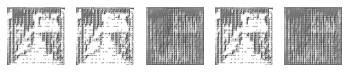

40, 1/53, d=0.000, g=12.532
40, 2/53, d=0.000, g=12.734
40, 3/53, d=0.000, g=12.498
40, 4/53, d=0.000, g=12.342
40, 5/53, d=0.000, g=12.496
40, 6/53, d=0.000, g=12.533
40, 7/53, d=0.000, g=12.594
40, 8/53, d=0.000, g=12.328
40, 9/53, d=0.000, g=12.604
40, 10/53, d=0.000, g=12.480
40, 11/53, d=0.000, g=12.510
40, 12/53, d=0.000, g=12.535
40, 13/53, d=0.000, g=12.845
40, 14/53, d=0.000, g=12.552
40, 15/53, d=0.000, g=12.452
40, 16/53, d=0.000, g=12.520
40, 17/53, d=0.000, g=12.469
40, 18/53, d=0.000, g=12.959
40, 19/53, d=0.000, g=12.444
40, 20/53, d=0.000, g=12.645
40, 21/53, d=0.000, g=12.632
40, 22/53, d=0.000, g=12.982
40, 23/53, d=0.000, g=12.779
40, 24/53, d=0.000, g=12.475
40, 25/53, d=0.000, g=12.403
40, 26/53, d=0.000, g=12.411
40, 27/53, d=0.000, g=12.556
40, 28/53, d=0.000, g=13.085
40, 29/53, d=0.000, g=12.154
40, 30/53, d=0.000, g=12.311
40, 31/53, d=0.000, g=12.701
40, 32/53, d=0.000, g=12.549
40, 33/53, d=0.000, g=12.651
40, 34/53, d=0.000, g=12.597
40, 35/53, d=0.000, g=1

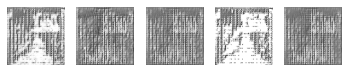

Accuracy real: 100%, fake: 100%
41, 1/53, d=0.000, g=12.822
41, 2/53, d=0.000, g=12.668
41, 3/53, d=0.000, g=12.739
41, 4/53, d=0.000, g=12.572
41, 5/53, d=0.000, g=12.469
41, 6/53, d=0.000, g=12.483
41, 7/53, d=0.000, g=12.788
41, 8/53, d=0.000, g=13.017
41, 9/53, d=0.000, g=12.715
41, 10/53, d=0.000, g=12.472
41, 11/53, d=0.000, g=12.603
41, 12/53, d=0.000, g=12.589
41, 13/53, d=0.000, g=12.824
41, 14/53, d=0.000, g=12.415
41, 15/53, d=0.000, g=12.620
41, 16/53, d=0.000, g=12.480
41, 17/53, d=0.000, g=13.098
41, 18/53, d=0.000, g=12.998
41, 19/53, d=0.000, g=12.422
41, 20/53, d=0.000, g=12.666
41, 21/53, d=0.000, g=12.684
41, 22/53, d=0.000, g=12.661
41, 23/53, d=0.000, g=12.761
41, 24/53, d=0.000, g=12.917
41, 25/53, d=0.000, g=12.712
41, 26/53, d=0.000, g=12.721
41, 27/53, d=0.000, g=12.425
41, 28/53, d=0.000, g=12.489
41, 29/53, d=0.000, g=12.417
41, 30/53, d=0.000, g=12.501
41, 31/53, d=0.000, g=12.448
41, 32/53, d=0.000, g=12.871
41, 33/53, d=0.000, g=12.543
41, 34/53, d=0.000, 

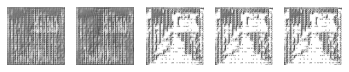

42, 1/53, d=0.000, g=12.623
42, 2/53, d=0.000, g=12.835
42, 3/53, d=0.000, g=13.167
42, 4/53, d=0.000, g=12.936
42, 5/53, d=0.000, g=12.653
42, 6/53, d=0.000, g=12.952
42, 7/53, d=0.000, g=12.727
42, 8/53, d=0.000, g=12.619
42, 9/53, d=0.000, g=12.502
42, 10/53, d=0.000, g=12.762
42, 11/53, d=0.000, g=12.521
42, 12/53, d=0.000, g=12.746
42, 13/53, d=0.000, g=12.997
42, 14/53, d=0.000, g=12.851
42, 15/53, d=0.000, g=12.848
42, 16/53, d=0.000, g=12.631
42, 17/53, d=0.000, g=12.830
42, 18/53, d=0.000, g=12.901
42, 19/53, d=0.000, g=12.844
42, 20/53, d=0.000, g=12.739
42, 21/53, d=0.000, g=12.711
42, 22/53, d=0.000, g=12.966
42, 23/53, d=0.000, g=12.760
42, 24/53, d=0.000, g=12.539
42, 25/53, d=0.000, g=12.660
42, 26/53, d=0.000, g=12.757
42, 27/53, d=0.000, g=12.958
42, 28/53, d=0.000, g=12.914
42, 29/53, d=0.000, g=12.942
42, 30/53, d=0.000, g=12.899
42, 31/53, d=0.000, g=12.925
42, 32/53, d=0.000, g=12.744
42, 33/53, d=0.000, g=12.924
42, 34/53, d=0.000, g=12.577
42, 35/53, d=0.000, g=1

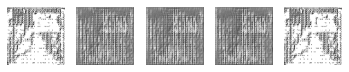

43, 1/53, d=0.000, g=12.718
43, 2/53, d=0.000, g=12.948
43, 3/53, d=0.000, g=12.779
43, 4/53, d=0.000, g=12.864
43, 5/53, d=0.000, g=12.833
43, 6/53, d=0.000, g=12.773
43, 7/53, d=0.000, g=12.889
43, 8/53, d=0.000, g=12.793
43, 9/53, d=0.000, g=13.069
43, 10/53, d=0.000, g=13.217
43, 11/53, d=0.000, g=12.786
43, 12/53, d=0.000, g=12.877
43, 13/53, d=0.000, g=12.873
43, 14/53, d=0.000, g=12.870
43, 15/53, d=0.000, g=12.885
43, 16/53, d=0.000, g=12.965
43, 17/53, d=0.000, g=13.041
43, 18/53, d=0.000, g=13.161
43, 19/53, d=0.000, g=13.343
43, 20/53, d=0.000, g=12.904
43, 21/53, d=0.000, g=12.928
43, 22/53, d=0.000, g=12.806
43, 23/53, d=0.000, g=12.797
43, 24/53, d=0.000, g=12.735
43, 25/53, d=0.000, g=12.852
43, 26/53, d=0.000, g=12.786
43, 27/53, d=0.000, g=13.048
43, 28/53, d=0.000, g=13.269
43, 29/53, d=0.000, g=13.086
43, 30/53, d=0.000, g=12.891
43, 31/53, d=0.000, g=13.021
43, 32/53, d=0.000, g=12.838
43, 33/53, d=0.000, g=12.859
43, 34/53, d=0.000, g=12.736
43, 35/53, d=0.000, g=1

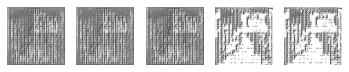

44, 1/53, d=0.000, g=12.992
44, 2/53, d=0.000, g=13.204
44, 3/53, d=0.000, g=13.003
44, 4/53, d=0.000, g=13.371
44, 5/53, d=0.000, g=13.040
44, 6/53, d=0.000, g=12.901
44, 7/53, d=0.000, g=12.924
44, 8/53, d=0.000, g=12.958
44, 9/53, d=0.000, g=12.892
44, 10/53, d=0.000, g=12.873
44, 11/53, d=0.000, g=12.765
44, 12/53, d=0.000, g=12.888
44, 13/53, d=0.000, g=13.178
44, 14/53, d=0.000, g=13.052
44, 15/53, d=0.000, g=13.093
44, 16/53, d=0.000, g=13.396
44, 17/53, d=0.000, g=13.055
44, 18/53, d=0.000, g=12.923
44, 19/53, d=0.000, g=13.121
44, 20/53, d=0.000, g=12.865
44, 21/53, d=0.000, g=13.026
44, 22/53, d=0.000, g=13.128
44, 23/53, d=0.000, g=13.014
44, 24/53, d=0.000, g=13.083
44, 25/53, d=0.000, g=13.098
44, 26/53, d=0.000, g=12.831
44, 27/53, d=0.000, g=13.234
44, 28/53, d=0.000, g=13.058
44, 29/53, d=0.000, g=12.895
44, 30/53, d=0.000, g=13.319
44, 31/53, d=0.000, g=13.244
44, 32/53, d=0.000, g=13.456
44, 33/53, d=0.000, g=13.657
44, 34/53, d=0.000, g=12.714
44, 35/53, d=0.000, g=1

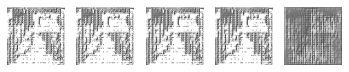

45, 1/53, d=0.000, g=13.376
45, 2/53, d=0.000, g=12.795
45, 3/53, d=0.000, g=13.325
45, 4/53, d=0.000, g=13.058
45, 5/53, d=0.000, g=13.202
45, 6/53, d=0.000, g=13.222
45, 7/53, d=0.000, g=13.338
45, 8/53, d=0.000, g=13.551
45, 9/53, d=0.000, g=13.162
45, 10/53, d=0.000, g=12.948
45, 11/53, d=0.000, g=12.909
45, 12/53, d=0.000, g=13.156
45, 13/53, d=0.000, g=13.369
45, 14/53, d=0.000, g=13.289
45, 15/53, d=0.000, g=13.731
45, 16/53, d=0.000, g=13.173
45, 17/53, d=0.000, g=13.012
45, 18/53, d=0.000, g=13.182
45, 19/53, d=0.000, g=13.208
45, 20/53, d=0.000, g=13.142
45, 21/53, d=0.000, g=13.256
45, 22/53, d=0.000, g=13.096
45, 23/53, d=0.000, g=13.076
45, 24/53, d=0.000, g=13.213
45, 25/53, d=0.000, g=13.153
45, 26/53, d=0.000, g=13.346
45, 27/53, d=0.000, g=13.450
45, 28/53, d=0.000, g=13.448
45, 29/53, d=0.000, g=13.143
45, 30/53, d=0.000, g=13.170
45, 31/53, d=0.000, g=12.883
45, 32/53, d=0.000, g=12.914
45, 33/53, d=0.000, g=13.355
45, 34/53, d=0.000, g=13.086
45, 35/53, d=0.000, g=1

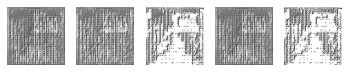

46, 1/53, d=0.000, g=13.187
46, 2/53, d=0.000, g=13.217
46, 3/53, d=0.000, g=13.252
46, 4/53, d=0.000, g=12.932
46, 5/53, d=0.000, g=13.424
46, 6/53, d=0.000, g=13.340
46, 7/53, d=0.000, g=13.515
46, 8/53, d=0.000, g=13.066
46, 9/53, d=0.000, g=13.329
46, 10/53, d=0.000, g=13.082
46, 11/53, d=0.000, g=13.228
46, 12/53, d=0.000, g=13.146
46, 13/53, d=0.000, g=13.247
46, 14/53, d=0.000, g=13.428
46, 15/53, d=0.000, g=13.432
46, 16/53, d=0.000, g=13.308
46, 17/53, d=0.000, g=13.259
46, 18/53, d=0.000, g=13.139
46, 19/53, d=0.000, g=13.281
46, 20/53, d=0.000, g=13.067
46, 21/53, d=0.000, g=13.294
46, 22/53, d=0.000, g=13.378
46, 23/53, d=0.000, g=13.176
46, 24/53, d=0.000, g=13.092
46, 25/53, d=0.000, g=13.181
46, 26/53, d=0.000, g=13.554
46, 27/53, d=0.000, g=13.267
46, 28/53, d=0.000, g=12.948
46, 29/53, d=0.000, g=13.033
46, 30/53, d=0.000, g=13.838
46, 31/53, d=0.000, g=13.974
46, 32/53, d=0.000, g=13.263
46, 33/53, d=0.000, g=13.349
46, 34/53, d=0.000, g=13.148
46, 35/53, d=0.000, g=1

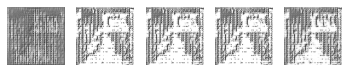

47, 1/53, d=0.000, g=13.455
47, 2/53, d=0.000, g=13.472
47, 3/53, d=0.000, g=13.192
47, 4/53, d=0.000, g=13.254
47, 5/53, d=0.000, g=12.920
47, 6/53, d=0.000, g=13.175
47, 7/53, d=0.000, g=13.410
47, 8/53, d=0.000, g=13.491
47, 9/53, d=0.000, g=13.277
47, 10/53, d=0.000, g=13.304
47, 11/53, d=0.000, g=13.212
47, 12/53, d=0.000, g=13.358
47, 13/53, d=0.000, g=13.163
47, 14/53, d=0.000, g=13.273
47, 15/53, d=0.000, g=13.447
47, 16/53, d=0.000, g=13.600
47, 17/53, d=0.000, g=13.221
47, 18/53, d=0.000, g=13.279
47, 19/53, d=0.000, g=13.024
47, 20/53, d=0.000, g=13.578
47, 21/53, d=0.000, g=13.462
47, 22/53, d=0.000, g=13.417
47, 23/53, d=0.000, g=13.336
47, 24/53, d=0.000, g=13.495
47, 25/53, d=0.000, g=13.536
47, 26/53, d=0.000, g=13.521
47, 27/53, d=0.000, g=13.398
47, 28/53, d=0.000, g=13.365
47, 29/53, d=0.000, g=13.614
47, 30/53, d=0.000, g=13.301
47, 31/53, d=0.000, g=13.586
47, 32/53, d=0.000, g=13.563
47, 33/53, d=0.000, g=13.290
47, 34/53, d=0.000, g=13.344
47, 35/53, d=0.000, g=1

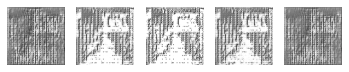

48, 1/53, d=0.000, g=13.201
48, 2/53, d=0.000, g=13.377
48, 3/53, d=0.000, g=13.458
48, 4/53, d=0.000, g=13.755
48, 5/53, d=0.000, g=13.427
48, 6/53, d=0.000, g=13.274
48, 7/53, d=0.000, g=13.459
48, 8/53, d=0.000, g=13.471
48, 9/53, d=0.000, g=13.504
48, 10/53, d=0.000, g=13.633
48, 11/53, d=0.000, g=13.563
48, 12/53, d=0.000, g=13.497
48, 13/53, d=0.000, g=13.371
48, 14/53, d=0.000, g=13.141
48, 15/53, d=0.000, g=13.441
48, 16/53, d=0.000, g=13.334
48, 17/53, d=0.000, g=13.382
48, 18/53, d=0.000, g=13.593
48, 19/53, d=0.000, g=13.393
48, 20/53, d=0.000, g=13.385
48, 21/53, d=0.000, g=13.360
48, 22/53, d=0.000, g=13.789
48, 23/53, d=0.000, g=13.634
48, 24/53, d=0.000, g=13.390
48, 25/53, d=0.000, g=13.278
48, 26/53, d=0.000, g=13.266
48, 27/53, d=0.000, g=13.141
48, 28/53, d=0.000, g=13.413
48, 29/53, d=0.000, g=13.094
48, 30/53, d=0.000, g=13.449
48, 31/53, d=0.000, g=13.224
48, 32/53, d=0.000, g=13.851
48, 33/53, d=0.000, g=13.819
48, 34/53, d=0.000, g=13.796
48, 35/53, d=0.000, g=1

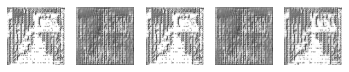

49, 1/53, d=0.000, g=13.228
49, 2/53, d=0.000, g=13.317
49, 3/53, d=0.000, g=13.708
49, 4/53, d=0.000, g=13.348
49, 5/53, d=0.000, g=13.572
49, 6/53, d=0.000, g=13.386
49, 7/53, d=0.000, g=13.338
49, 8/53, d=0.000, g=13.219
49, 9/53, d=0.000, g=13.492
49, 10/53, d=0.000, g=13.598
49, 11/53, d=0.000, g=13.584
49, 12/53, d=0.000, g=13.520
49, 13/53, d=0.000, g=13.643
49, 14/53, d=0.000, g=13.544
49, 15/53, d=0.000, g=13.206
49, 16/53, d=0.000, g=13.437
49, 17/53, d=0.000, g=13.219
49, 18/53, d=0.000, g=13.589
49, 19/53, d=0.000, g=13.471
49, 20/53, d=0.000, g=13.700
49, 21/53, d=0.000, g=13.416
49, 22/53, d=0.000, g=13.459
49, 23/53, d=0.000, g=13.383
49, 24/53, d=0.000, g=13.291
49, 25/53, d=0.000, g=13.486
49, 26/53, d=0.000, g=13.796
49, 27/53, d=0.000, g=13.715
49, 28/53, d=0.000, g=14.061
49, 29/53, d=0.000, g=13.496
49, 30/53, d=0.000, g=13.688
49, 31/53, d=0.000, g=13.254
49, 32/53, d=0.000, g=13.332
49, 33/53, d=0.000, g=13.604
49, 34/53, d=0.000, g=13.615
49, 35/53, d=0.000, g=1

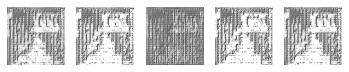

50, 1/53, d=0.000, g=13.498
50, 2/53, d=0.000, g=13.470
50, 3/53, d=0.000, g=13.534
50, 4/53, d=0.000, g=13.651
50, 5/53, d=0.000, g=13.662
50, 6/53, d=0.000, g=13.770
50, 7/53, d=0.000, g=13.404
50, 8/53, d=0.000, g=13.579
50, 9/53, d=0.000, g=13.374
50, 10/53, d=0.000, g=13.465
50, 11/53, d=0.000, g=13.392
50, 12/53, d=0.000, g=13.449
50, 13/53, d=0.000, g=13.366
50, 14/53, d=0.000, g=13.673
50, 15/53, d=0.000, g=13.718
50, 16/53, d=0.000, g=13.886
50, 17/53, d=0.000, g=13.677
50, 18/53, d=0.000, g=13.694
50, 19/53, d=0.000, g=13.238
50, 20/53, d=0.000, g=13.414
50, 21/53, d=0.000, g=13.673
50, 22/53, d=0.000, g=13.433
50, 23/53, d=0.000, g=13.418
50, 24/53, d=0.000, g=13.487
50, 25/53, d=0.000, g=13.490
50, 26/53, d=0.000, g=13.328
50, 27/53, d=0.000, g=13.357
50, 28/53, d=0.000, g=13.602
50, 29/53, d=0.000, g=13.597
50, 30/53, d=0.000, g=13.516
50, 31/53, d=0.000, g=13.263
50, 32/53, d=0.000, g=13.315
50, 33/53, d=0.000, g=13.449
50, 34/53, d=0.000, g=13.490
50, 35/53, d=0.000, g=1

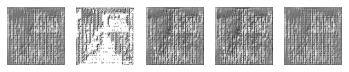

Accuracy real: 100%, fake: 100%


In [ ]:
train_GAN(model_G, model_D, model_GAN, dataset, latent_dim)